Task: Predict whether a user will vote on another user's posting

We use the network data (graph.pkl) which was created in the dataset preparation notebook

In [146]:
import os

# Define the requirements.txt path
requirements_file = "requirements.txt"

# Check if the file exists
if os.path.exists(requirements_file):
    # Install the required libraries
    !pip install -r {requirements_file}
else:
    print(f"{requirements_file} not found. Please ensure it exists.")

requirements.txt not found. Please ensure it exists.


In [137]:
import node2vec
from node2vec import Node2Vec
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from linkpred import LinkPred
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import numpy as np
import random
import seaborn as sns
import pickle
from pandas.plotting import parallel_coordinates
#from torch_geometric.nn import Node2Vec 

### Link Prediction

In [95]:
# Load the graph from dataset preparation
with open("graph.pkl", "rb") as f:
    G_undirected = pickle.load(f)

# Verify the graph is loaded
print(f"Graph: {G_undirected.number_of_nodes()} nodes, {G_undirected.number_of_edges()} edges")
#######$

Graph: 10964 nodes, 529434 edges


In [96]:
# check if its directed
G_undirected.is_directed()


False

In [97]:
# Sample a smaller subgraph
subgraph = G_undirected.subgraph(list(G_undirected.nodes)[:1000])  # Adjust size 

# G_directed = subgraph # comment it out when using the full graph


In [98]:
#check number of nodes
subgraph.number_of_nodes()

1000

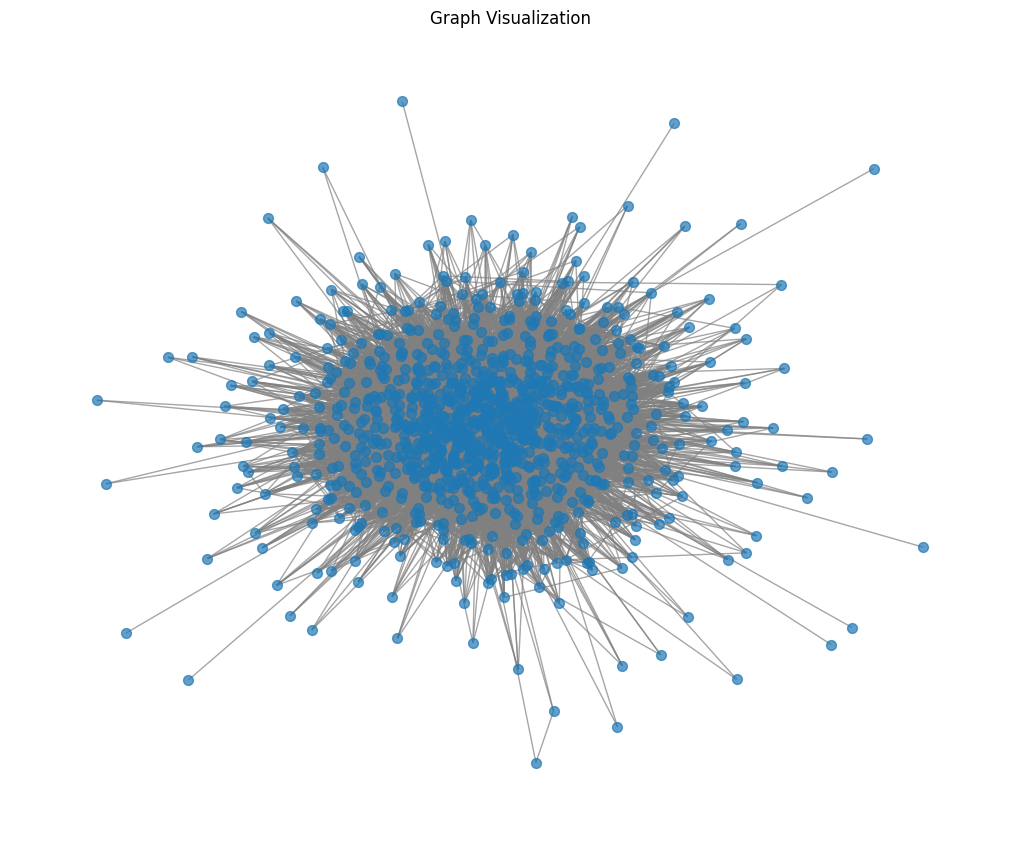

In [99]:
# Visualize the subgraph with basic layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph) 
nx.draw(
    subgraph, 
    pos, 
    with_labels=False, 
    node_size=50, 
    edge_color='gray', 
    alpha=0.7
)
plt.title("Graph Visualization")
plt.show()

### Train Test and Validation Split

In [100]:
graph = subgraph # comment it out when using the full
# graph = G_undirected # comment it out when using the subgraph

In [101]:
len(graph.edges)

35141

In [102]:
# 1. Extract all edges (positive examples)
edges = list(graph.edges())

# 2. Split edges into train/test (85% train+val, 15% test)
train_val_edges, test_edges = train_test_split(edges, test_size=0.15, random_state=42)

# 3. Split train_val into train (70%) and validation (15%)
train_edges, val_edges = train_test_split(train_val_edges, test_size=0.1765, random_state=42)  # 0.1765 ≈ 15% of 85%

# 4. Create the train graph (only training edges)
graph_train = graph.copy()
graph_train.remove_edges_from(val_edges)
graph_train.remove_edges_from(test_edges)

# Ensure all nodes from the original graph are in the train graph
graph_train.add_nodes_from(graph.nodes())

# Print statistics
print(f"Original Graph: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges")
print(f"Train Graph: {graph_train.number_of_nodes()} nodes, {graph_train.number_of_edges()} edges")
print(f"Training Edges: {len(train_edges)}")
print(f"Validation Edges: {len(val_edges)}")
print(f"Test Edges: {len(test_edges)}")

Original Graph: 1000 nodes, 35141 edges
Train Graph: 1000 nodes, 24597 edges
Training Edges: 24597
Validation Edges: 5272
Test Edges: 5272


In [103]:
# Generate negative edges (non-edges)
all_non_edges = set(nx.non_edges(graph))

# Sample negative edges for each set
train_neg_edges = random.sample(list(all_non_edges), len(train_edges))
val_neg_edges = random.sample(list(all_non_edges - set(train_neg_edges)), len(val_edges))
test_neg_edges = random.sample(list(all_non_edges - set(train_neg_edges) - set(val_neg_edges)), len(test_edges))

# Verify counts
print(f"Train Negative Edges: {len(train_neg_edges)}")
print(f"Validation Negative Edges: {len(val_neg_edges)}")
print(f"Test Negative Edges: {len(test_neg_edges)}")



Train Negative Edges: 24597
Validation Negative Edges: 5272
Test Negative Edges: 5272


### Train and evaluate link prediction model using node2vec

In [104]:
# Calculate node embeddings with Node2Vec on the training graph

node2vec_train = Node2Vec(
    graph=graph_train, # Use the training graph
    dimensions=64,    # Embedding dimensions
    walk_length=30,   # Length of random walks
    num_walks=200,    # Number of random walks per node
    workers=4         # Parallel threads
)

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


In [105]:
# Fit the model and extract embeddings
model_train = node2vec_train.fit()
embeddings_train = {node: model_train.wv[str(node)] for node in graph_train.nodes()}

# Verify embeddings
print(f"Number of nodes in train_graph: {graph_train.number_of_nodes()}")
print(f"Number of generated embeddings: {len(embeddings_train)}")

Number of nodes in train_graph: 1000
Number of generated embeddings: 1000


In [106]:
def embedding_train(node):
    return model_train.wv[str(node)]

In [107]:
# verify embeddings
for node in list(graph_train.nodes())[:5]:
    print(f"Node {node}: {embeddings_train[node]}")

Node 163840: [-2.03875124e-01  7.70076513e-02  2.54552960e-02 -2.89555281e-01
  4.38607365e-01  3.09164375e-02  4.34669048e-01 -1.04521595e-01
 -5.75206161e-01  1.48238223e-02  5.57777956e-02  1.27152190e-01
 -6.58690631e-01 -4.44539748e-02 -9.05723572e-02  6.91424966e-01
 -5.84282160e-01  6.14558905e-02 -3.96980606e-02  2.64297634e-01
 -7.64711946e-02  1.08426109e-01 -1.04568126e-02  2.46467382e-01
 -5.20467125e-02  5.40349007e-01 -2.78573781e-01  7.46086016e-02
 -8.51237103e-02  1.38834685e-01  1.73504055e-02  3.82959068e-01
  2.80391216e-01 -2.21589670e-01  2.71657974e-01  8.23783875e-02
 -1.11244932e-01  2.55953044e-01  1.12536207e-01  5.19205153e-01
 -4.96516466e-01 -2.92369217e-01 -2.46673062e-01 -2.71480368e-03
  1.18464923e-05  2.56247103e-01 -2.93900639e-01 -3.01940902e-03
 -4.04255062e-01 -3.39482427e-01  9.43066403e-02  6.17934942e-01
 -6.76632345e-01  9.04303566e-02  1.82227224e-01  4.76413190e-01
  1.24811148e-03  4.93079960e-01 -3.20794851e-01  8.29314217e-02
  1.15230151

In [108]:
# Define binary operators
def operator_hadamard(u, v):
    return u * v  # Element-wise product

def operator_l1(u, v):
    return np.abs(u - v)  # L1 distance

def operator_l2(u, v):
    return (u - v) ** 2  # L2 distance

def operator_avg(u, v):
    return (u + v) / 2  # Average

# List of operators
binary_operators = {
    "Hadamard": operator_hadamard,
    "L1": operator_l1,
    "L2": operator_l2,
    "Average": operator_avg
}

In [109]:
def generate_features(edges_pos, edges_neg, embedding_func, binary_operator):
    
    # Generate features for positive edges
    X_pos = [
        binary_operator(embedding_func(u), embedding_func(v))
        for u, v in edges_pos if str(u) in model_train.wv and str(v) in model_train.wv
    ]
    
    # Generate features for negative edges
    X_neg = [
        binary_operator(embedding_func(u), embedding_func(v))
        for u, v in edges_neg if str(u) in model_train.wv and str(v) in model_train.wv
    ]
    
    # Combine features and labels
    X = np.vstack([X_pos, X_neg])
    y = [1] * len(X_pos) + [0] * len(X_neg)
    
    return X, y

def evaluate_operator_consistently(operator_name, operator_func, embeddings_func, train_edges, train_neg_edges, val_edges, val_neg_edges):
    
    print(f"Evaluating binary operator: {operator_name}")
    
    # Generate features for training set
    X_train, y_train = generate_features(train_edges, train_neg_edges, embeddings_func, operator_func)
    
    # Train logistic regression classifier
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    
    # Generate features for validation set
    X_val, y_val = generate_features(val_edges, val_neg_edges, embeddings_func, operator_func)
    
    # Predict probabilities for the validation set
    y_val_proba = clf.predict_proba(X_val)[:, 1]  # Probability of the positive class (1)
    
    # Compute ROC AUC
    val_auc = roc_auc_score(y_val, y_val_proba)
    return val_auc

In [110]:
# Store results
operator_results = {}

# Iterate through each binary operator
for operator_name, operator_func in binary_operators.items():
    # Evaluate the operator on the training and validation sets
    val_auc = evaluate_operator_consistently(
        operator_name=operator_name,
        operator_func=operator_func,
        embeddings_func=embedding_train,
        train_edges=train_edges,
        train_neg_edges=train_neg_edges,
        val_edges=val_edges,
        val_neg_edges=val_neg_edges
    )
    
    # Store the result
    operator_results[operator_name] = val_auc
    print(f"Validation ROC AUC for {operator_name}: {val_auc:.4f}")

# Find the best operator
best_operator = max(operator_results, key=operator_results.get)
best_auc = operator_results[best_operator]
print(f"\nBest Operator: {best_operator}")
print(f"Best Validation ROC AUC: {best_auc:.4f}")

Evaluating binary operator: Hadamard
Validation ROC AUC for Hadamard: 0.5397
Evaluating binary operator: L1
Validation ROC AUC for L1: 0.7823
Evaluating binary operator: L2
Validation ROC AUC for L2: 0.7894
Evaluating binary operator: Average
Validation ROC AUC for Average: 0.7948

Best Operator: Average
Best Validation ROC AUC: 0.7948


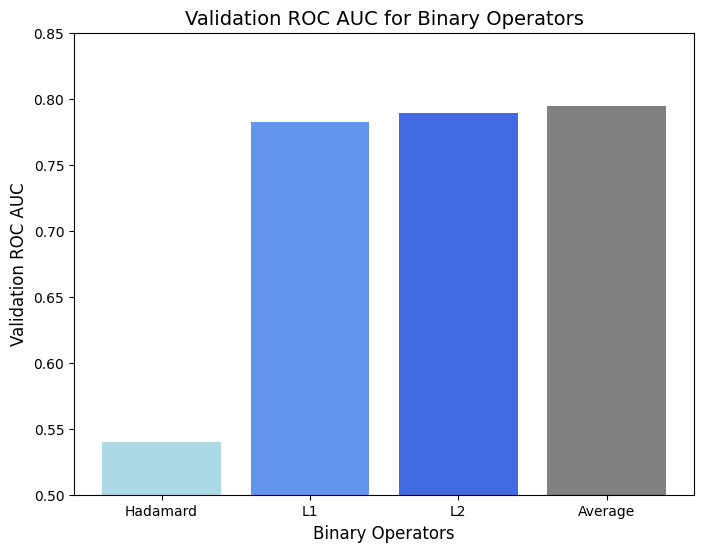

In [143]:
# Data for binary operator evaluation
operators = ["Hadamard", "L1", "L2", "Average"]

roc_auc_scores = [0.5397, 0.7823, 0.7894, 0.7948]
plt.figure(figsize=(8, 6))
colors = ["lightblue", "cornflowerblue", "royalblue", "grey"]

plt.bar(operators, roc_auc_scores, color=colors)
plt.ylim(0.5, 0.85)
plt.title("Validation ROC AUC for Binary Operators", fontsize=14)
plt.xlabel("Binary Operators", fontsize=12)
plt.ylabel("Validation ROC AUC", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [111]:
# Select the binary operator 
selected_operator = operator_avg

# Generate features for training set
X_train, y_train = generate_features(
    train_edges, train_neg_edges, embedding_train, selected_operator
)

# Verify outputs
print(f"Train Features: {len(X_train)}, Positive Edges: {y_train.count(1)}, Negative Edges: {y_train.count(0)}")

# Generate features for validation set
X_val, y_val = generate_features(
    val_edges, val_neg_edges, embedding_train, selected_operator
)

# Verify outputs
print(f"Validation Features: {len(X_val)}, Positive Edges: {y_val.count(1)}, Negative Edges: {y_val.count(0)}")

Train Features: 49194, Positive Edges: 24597, Negative Edges: 24597
Validation Features: 10544, Positive Edges: 5272, Negative Edges: 5272


In [112]:
# Train the logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [113]:
# Predict probabilities for the validation set
y_val_proba = clf.predict_proba(X_val)[:, 1]  # Probability of the positive class (1)

# Compute ROC AUC
val_auc = roc_auc_score(y_val, y_val_proba)

print(f"Validation ROC AUC: {val_auc:.4f}")

Validation ROC AUC: 0.7948


### Evaluate the model using the test set 

In [114]:
graph_test = graph.copy()  # Replace `graph` with your main graph variable
graph_test.remove_edges_from(train_edges + val_edges)

In [115]:
# Train Node2Vec on the test graph
node2vec_test = Node2Vec(
    graph_test,  # Use the test graph
    dimensions=64,
    walk_length=30,
    num_walks=200,
    workers=4
)

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:03<00:00, 14.47it/s]


In [116]:
model_test = node2vec_test.fit()

# Create a function to retrieve test embeddings
def embedding_test(node):
    return model_test.wv[str(node)]

In [117]:
# Generate features for the test set
X_test, y_test = generate_features(
    test_edges,       # Positive test edges
    test_neg_edges,   # Negative test edges
    embedding_test,   # Function to retrieve embeddings for test nodes
    operator_avg # Selected binary operator
)

# Verify outputs
print(f"Test Features: {len(X_test)}, Positive Edges: {y_test.count(1)}, Negative Edges: {y_test.count(0)}")

Test Features: 10544, Positive Edges: 5272, Negative Edges: 5272


In [118]:
# Predict probabilities and labels for the test set
y_test_proba = clf.predict_proba(X_test)[:, 1]
y_test_pred = clf.predict(X_test)

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

Test Accuracy: 0.5002
Test ROC AUC: 0.5271


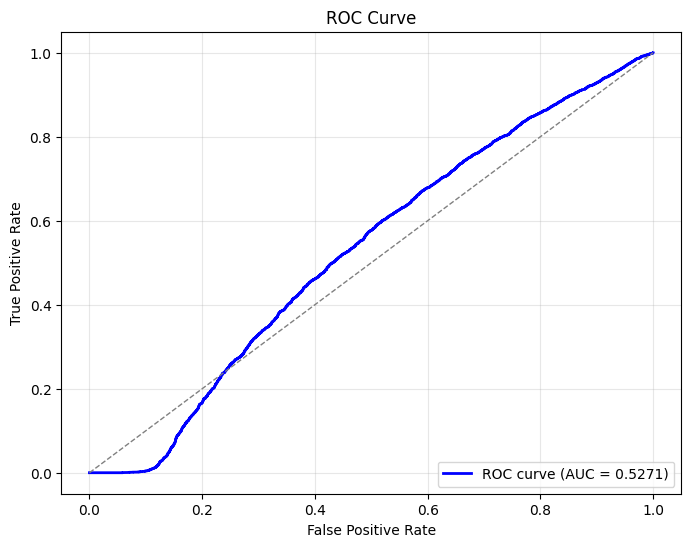

In [119]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Tune Node2vec

#### Helper function for the generator and operator

In [120]:
# Define the operator
def operator_hadamard(embedding1, embedding2):
    """
    Computes the Hadamard operator (element-wise product) for two embeddings.
    """
    return embedding1 * embedding2



# Define the feature generator
def generate_features_with_operator(edges, embeddings, operator):
    """
    Generates features for a set of edges using the given operator and embeddings.
    """
    features = []
    for edge in edges:
        source, target = edge
        source_embedding = embeddings[source]
        target_embedding = embeddings[target]
        features.append(operator(source_embedding, target_embedding))
    return np.array(features)


In [121]:

def train_node2vec(graph, dimensions, walk_length, num_walks, p, q):
    """
    Trains a Node2Vec model and returns the learned embeddings.
    """
    node2vec = Node2Vec(
        graph=graph,
        dimensions=dimensions,
        walk_length=walk_length,
        num_walks=num_walks,
        workers=4,
        p=p,
        q=q
    )
    model = node2vec.fit()
    embeddings = {node: model.wv[str(node)] for node in graph.nodes()}
    return embeddings


In [122]:

def evaluate_on_validation_set(clf, embeddings, val_edges, val_neg_edges):
    """
    Evaluates the classifier on the validation set and computes the ROC AUC.
    """
    # Generate features
    X_val_pos = generate_features_with_operator(val_edges, embeddings, operator_hadamard)
    X_val_neg = generate_features_with_operator(val_neg_edges, embeddings, operator_hadamard)

    X_val = np.vstack([X_val_pos, X_val_neg])
    y_val = [1] * len(X_val_pos) + [0] * len(X_val_neg)
    
    # Predict probabilities
    y_val_proba = clf.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_val_proba)
    return val_auc


In [123]:
import csv
from itertools import product

def tune_parameters(graph_train, X_train, y_train, val_edges, val_neg_edges, dimensions=64, output_file="parameter_results.csv"):
    """
    Tunes Node2Vec parameters, saves results to a file, and print only the best parameters.
    """
    # Parameter grid
    walk_length_list = [10, 20, 30, 50]
    num_walks_list = [10, 20, 50, 100, 200]
    p_list = [0.5, 1, 2]
    q_list = [0.5, 1, 2]

    best_auc = 0
    best_params = None
    results = []

    # CSV header
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Walk Length", "Num Walks", "p", "q", "Validation ROC AUC"])

        # Parameter tuning
        for walk_length, num_walks, p, q in product(walk_length_list, num_walks_list, p_list, q_list):
            # Train Node2Vec with current parameters
            node2vec = Node2Vec(
                graph=graph_train,
                dimensions=dimensions,
                walk_length=walk_length,
                num_walks=num_walks,
                workers=4,
                p=p,
                q=q,
                quiet=True
            )
            model = node2vec.fit()
            embeddings = {node: model.wv[str(node)] for node in graph_train.nodes()}

            # Generate validation features dynamically
            X_val_pos = [
                operator_avg(embeddings[u], embeddings[v])
                for u, v in val_edges if str(u) in model.wv and str(v) in model.wv
            ]
            X_val_neg = [
                operator_avg(embeddings[u], embeddings[v])
                for u, v in val_neg_edges if str(u) in model.wv and str(v) in model.wv
            ]
            X_val = np.vstack([X_val_pos, X_val_neg])
            y_val = [1] * len(X_val_pos) + [0] * len(X_val_neg)

            # Train logistic regression classifier
            clf = LogisticRegression(max_iter=1000, random_state=42)
            clf.fit(X_train, y_train)

            # Evaluate on validation set
            y_val_proba = clf.predict_proba(X_val)[:, 1]
            val_auc = roc_auc_score(y_val, y_val_proba)

            # Save results to file
            results.append((walk_length, num_walks, p, q, val_auc))
            writer.writerow([walk_length, num_walks, p, q, val_auc])

            # Update best parameters if necessary
            if val_auc > best_auc:
                best_auc = val_auc
                best_params = (walk_length, num_walks, p, q)

    # Print final best parameters
    print(f"Best Parameters: walk_length={best_params[0]}, num_walks={best_params[1]}, p={best_params[2]}, q={best_params[3]}")
    print(f"Best Validation ROC AUC: {best_auc:.4f}")

    return best_params, best_auc


In [124]:
# Run parameter tuning
best_params, best_auc = tune_parameters(graph_train, X_train, y_train, val_edges, val_neg_edges)


Best Parameters: walk_length=10, num_walks=200, p=2, q=0.5
Best Validation ROC AUC: 0.6884


In [134]:
# Load the CSV file
results_df = pd.read_csv("parameter_results.csv")

# Display the first few rows
print(results_df.head())

   Walk Length  Num Walks    p    q  Validation ROC AUC
0           10         10  0.5  0.5            0.511077
1           10         10  0.5  1.0            0.486345
2           10         10  0.5  2.0            0.433636
3           10         10  1.0  0.5            0.487074
4           10         10  1.0  1.0            0.485606


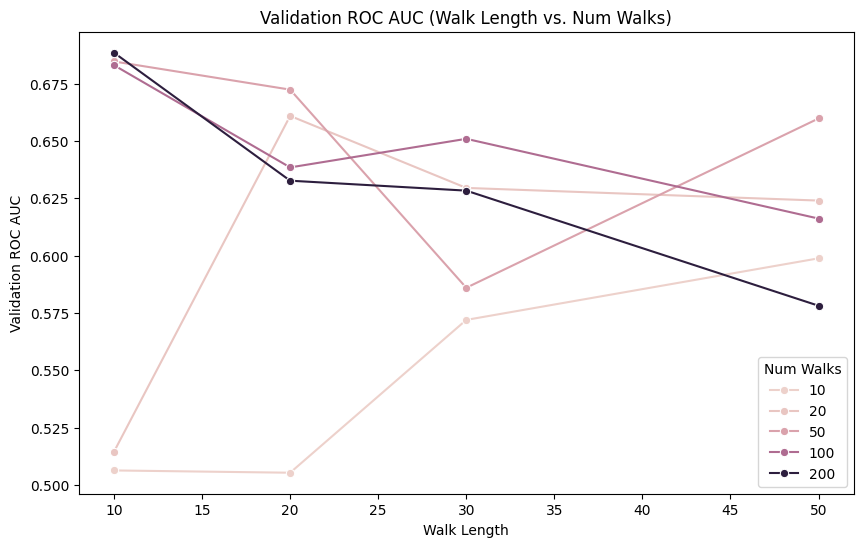

In [139]:
filtered_df = results_df[(results_df["p"] == 2) & (results_df["q"] == 0.5)]

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=filtered_df,
    x="Walk Length",
    y="Validation ROC AUC",
    hue="Num Walks",
    marker="o"
)
plt.title("Validation ROC AUC (Walk Length vs. Num Walks)")
plt.xlabel("Walk Length")
plt.ylabel("Validation ROC AUC")
plt.legend(title="Num Walks", loc="best")
plt.show()

### Train with Best Parameters

In [127]:
# Unpack the best parameters
best_walk_length, best_num_walks, best_p, best_q = best_params

# Train Node2Vec using the best parameters
node2vec_final = Node2Vec(
    graph=graph_train,
    dimensions=64,  # Same dimensions as during tuning
    walk_length=best_walk_length,
    num_walks=best_num_walks,
    workers=4,
    p=best_p,
    q=best_q
)
model_final = node2vec_final.fit()
embeddings_final = {node: model_final.wv[str(node)] for node in graph_train.nodes()}


Generating walks (CPU: 4): 100%|██████████| 50/50 [00:03<00:00, 15.71it/s]


In [128]:
# Verify embeddings
print(f"Number of nodes in train_graph: {graph_train.number_of_nodes()}")
print(f"Number of generated embeddings: {len(embeddings_final)}")

Number of nodes in train_graph: 1000
Number of generated embeddings: 1000


In [129]:
def embedding_final(node):
    return model_final.wv[str(node)] if str(node) in model_final.wv else np.zeros(64)  # Assuming 64 dimensions

In [130]:
# Generate features for the training set
X_train_final, y_train_final = generate_features(
    train_edges,         # Positive edges
    train_neg_edges,     # Negative edges
    embedding_final,     # Safe embedding function
    operator_avg    # Binary operator (Average in this case)
)

# Verify outputs
print(f"Train Features: {len(X_train_final)}")
print(f"Positive Edges: {y_train_final.count(1)}, Negative Edges: {y_train_final.count(0)}")

Train Features: 49194
Positive Edges: 24597, Negative Edges: 24597


In [131]:

# Train logistic regression on the final training set
clf_final = LogisticRegression(max_iter=1000, random_state=42)
clf_final.fit(X_train_final, y_train_final)


LogisticRegression(max_iter=1000, random_state=42)

In [132]:
X_test, y_test = generate_features(
    test_edges,         # Positive test edges
    test_neg_edges,     # Negative test edges
    embedding_final,    # Safe embedding function for test embeddings
    operator_avg   # Binary operator 
)

# Verify outputs
print(f"Test Features: {len(X_test)}")
print(f"Positive Edges: {y_test.count(1)}, Negative Edges: {y_test.count(0)}")

Test Features: 10544
Positive Edges: 5272, Negative Edges: 5272


In [133]:
# Predict probabilities and labels for the test set
y_test_proba = clf_final.predict_proba(X_test)[:, 1]
y_test_pred = clf_final.predict(X_test)

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

Test Accuracy: 0.7348
Test ROC AUC: 0.8012


In [160]:
with open("node2vec_final.pkl", "wb") as f:
    pickle.dump(node2vec_final, f)

In [164]:
with open("node2vec_final.pkl", "rb") as f:
    model_loaded = pickle.load(f)

In [165]:
model_loaded